In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent))
import scripts.eda_toolkit as eda
import sklearn
from sklearn.model_selection import train_test_split
import scripts.functions as fn
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
RANDOM_STATE = 8

home = Path.cwd().parent
data_dir = home / "data"
notebook_dir = home / "notebooks"
df = pd.read_csv(data_dir / "processed" / "train_data.csv")
sklearn.set_config(transform_output="pandas")

In [3]:
print(f"Training set shape: {df.shape}")

Training set shape: (841, 21)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=["class"]),
    df["class"],
    test_size=150,
    random_state=RANDOM_STATE,
    stratify=df["class"]
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((691, 20), (691,), (150, 20), (150,))

In [4]:
X_train.head()

,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account_bonds,present_employment_since,installment_rate_pct_of_disp_income,personal_status_sex,other_debtors_guarantors,present_residence_since,property,age_years,other_installment_plans,housing,existing_credits_count,job,people_liable_for_maintenance,telephone,foreign_worker
237,0 <= ... < 200 DM,12,existing credits paid duly,furniture/equipment,983,>= 1000 DM,< 1 year,1,female: div/sep/married,none,4,real estate,19,none,rent,1,unskilled resident,1,none,yes
278,< 0 DM,11,critical/other credits exist,car (new),3905,< 100 DM,1 <= ... < 4 years,2,male: single,none,2,real estate,36,none,rent,2,skilled employee/official,2,none,yes
482,0 <= ... < 200 DM,36,delay in paying off in past,car (new),7432,< 100 DM,1 <= ... < 4 years,2,female: div/sep/married,none,2,bldg society/life ins.,54,none,rent,1,skilled employee/official,1,none,yes
238,< 0 DM,6,critical/other credits exist,radio/television,1957,< 100 DM,4 <= ... < 7 years,1,female: div/sep/married,none,4,car or other,31,none,own,1,skilled employee/official,1,none,yes
732,< 0 DM,24,all credits here paid duly,others,1358,unknown/no savings account,>= 7 years,4,male: single,none,3,car or other,40,stores,own,1,management/self-employed/etc,1,"yes, registered",yes


### Take a look at the variables

In [ ]:
for col in train_df.columns:
    if train_df[col].dtype in [int, float]:
        eda.analyze_numerical(train_df[col])
        eda.analyze_categorical_numerical(y_train, train_df[col], parametric=False)
    else:
        eda.analyze_categorical(train_df[col])
        eda.analyze_categorical_categorical(train_df[col], y_train)

<hr>

## SVC

Baseline model + simplest transformations

In [4]:
X_baseline = pd.DataFrame(fn.BaselineEngineer().fit_transform(X_train))

In [5]:
from scripts.train_svc import svc_preprocess, train_svc


X_train_processed_svc, full_pipeline_svc = svc_preprocess(X_train, y_train)
X_train_processed_svc = pd.DataFrame(X_train_processed_svc)


basic_model_svc = SVC(random_state=RANDOM_STATE, probability=True)

basic_pipeline_svc = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_svc)
])

eng_pipeline_svc = Pipeline(steps=[
    ("full_pipeline", full_pipeline_svc),
    ("model", basic_model_svc)
])

basic_pipeline_svc.fit(X_train, y_train)
eng_pipeline_svc.fit(X_train, y_train)

X_train_processed_svc.shape, X_baseline.shape

((691, 41), (691, 61))

ROC AUC: 0.9628 ± 0.0017 (train), 0.7771 ± 0.0315 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


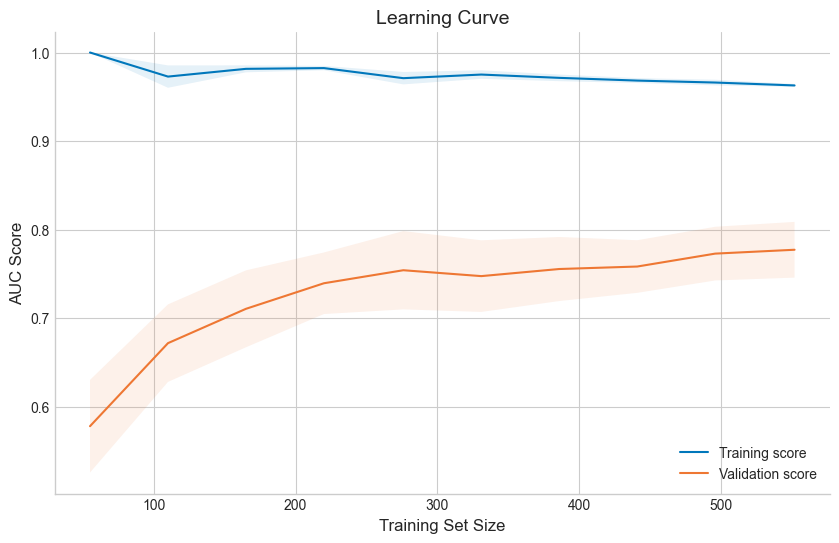

ROC AUC: 0.9258 ± 0.0026 (train), 0.7898 ± 0.0317 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


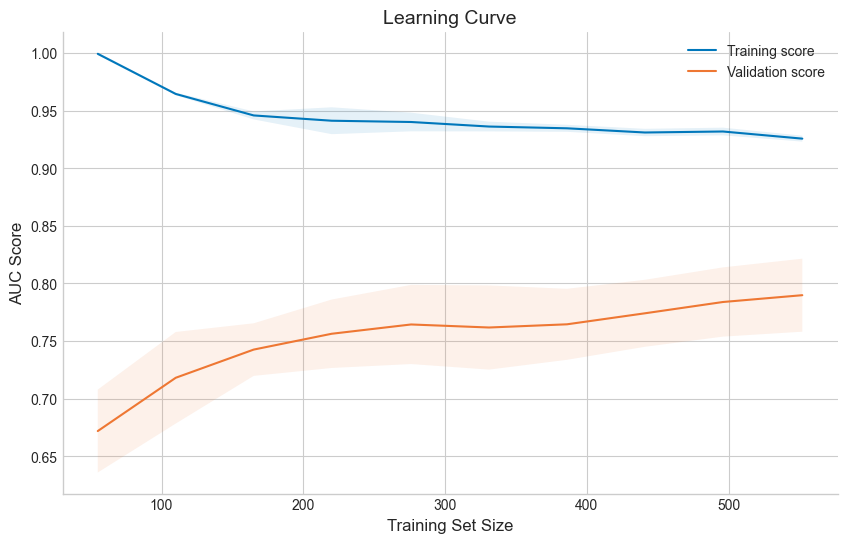

In [6]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

_ , res_svc_base = fn.plot_learning_curve(basic_model_svc, X_baseline, y_train)
_ , res_svc_eng = fn.plot_learning_curve(basic_model_svc, X_train_processed_svc, y_train)

In [8]:
diff = res_svc_eng['lc_val_auc_final'] - res_svc_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0127


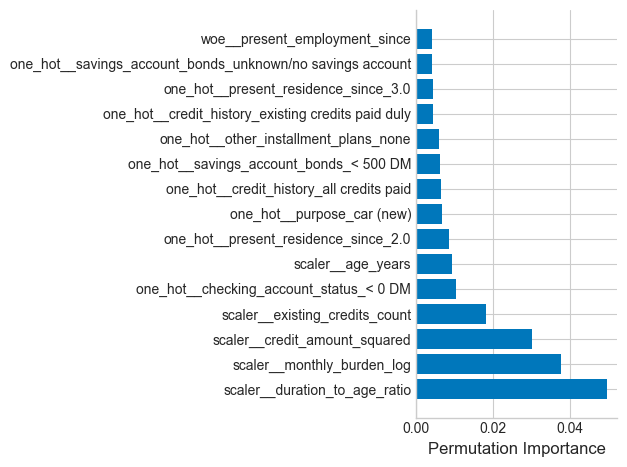

In [9]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    basic_model_svc,
    X_train_processed_svc,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:15]
axes.barh(range(15), result.importances_mean[indices])
axes.set_yticks(range(15))
axes.set_yticklabels(X_train_processed_svc.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


<hr>

## Logistic Regression

In [10]:
from scripts.train_lrc import lrc_preprocess, train_lrc
from sklearn.linear_model import LogisticRegression

X_train_processed_lrc, full_pipeline_lrc = lrc_preprocess(X_train, y_train)
X_train_processed_lrc = pd.DataFrame(X_train_processed_lrc)

basic_model_lrc = LogisticRegression(random_state=RANDOM_STATE)

basic_pipeline_lrc = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_lrc)
])

eng_pipeline_lrc = Pipeline(steps=[
    ("full_pipeline", full_pipeline_lrc),
    ("model", basic_model_lrc)
])

basic_pipeline_lrc.fit(X_train, y_train)
eng_pipeline_lrc.fit(X_train, y_train)

X_train_processed_lrc.shape, X_baseline.shape

((691, 37), (691, 61))

ROC AUC: 0.8492 ± 0.0080 (train), 0.7579 ± 0.0360 (validation)

🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning


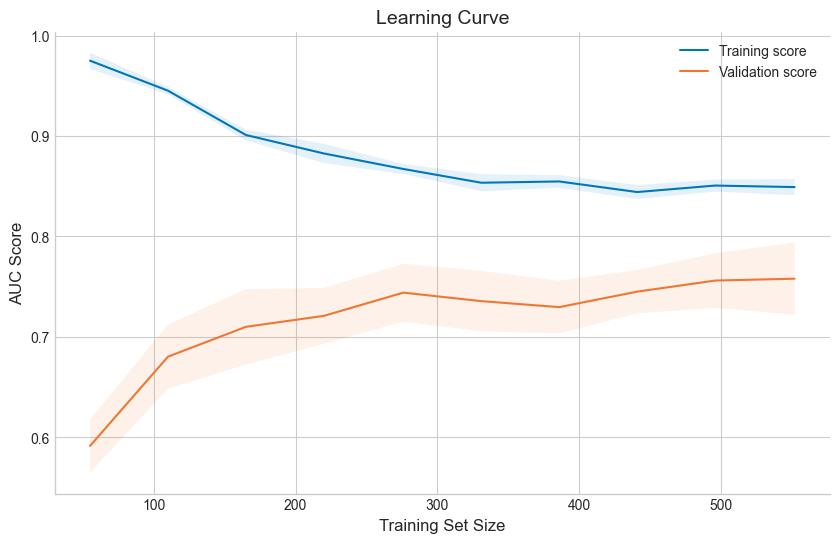

ROC AUC: 0.8331 ± 0.0056 (train), 0.7902 ± 0.0265 (validation)

🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning


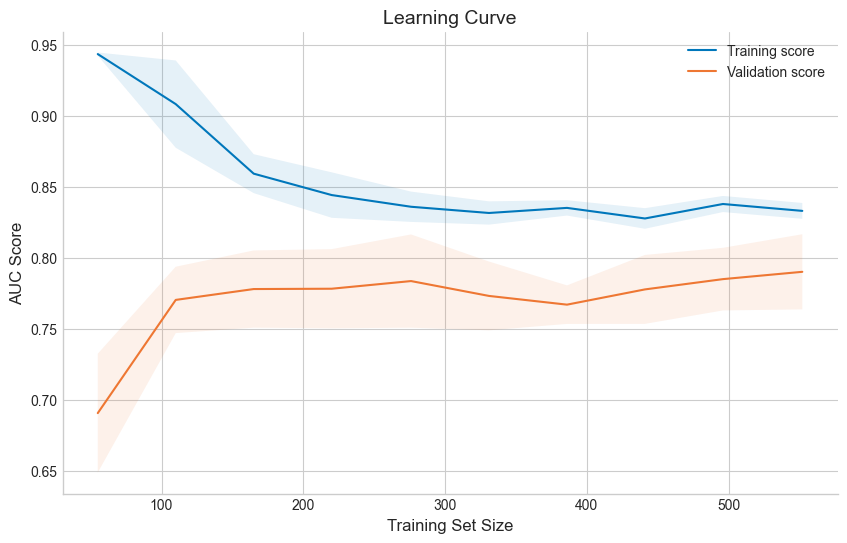

In [12]:
_ , res_lrc_base = fn.plot_learning_curve(basic_model_lrc, X_baseline, y_train)
_ , res_lrc_eng = fn.plot_learning_curve(basic_model_lrc, X_train_processed_lrc, y_train)

In [13]:
diff = res_lrc_eng['lc_val_auc_final'] - res_lrc_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0323


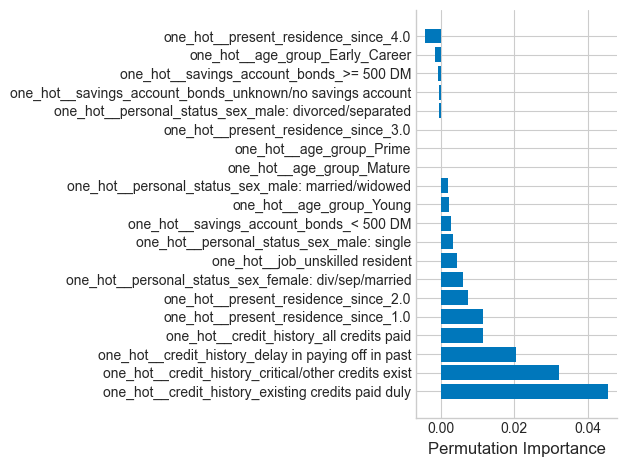

In [16]:
result = permutation_importance(
    eng_pipeline_lrc,
    X_train,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:20]
axes.barh(range(20), result.importances_mean[indices])
axes.set_yticks(range(20))
axes.set_yticklabels(X_train_processed_lrc.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

Top 15 Most Important Features by Coefficient Magnitude:
Feature                                                Coefficient
----------------------------------------------------------------------
woe__purpose                                                0.9632
one_hot__credit_history_all credits paid                   -0.8459
woe__checking_account_status                                0.7903
one_hot__credit_history_critical/other credits exist          0.6586
woe__property                                               0.6536
woe__present_employment_since                               0.6415
count__other_installment_plans                              0.5679
one_hot__present_residence_since_2.0                       -0.4377
count__installment_rate_pct_of_disp_income                 -0.4304
one_hot__age_group_Young                                   -0.4216
one_hot__foreign_worker_no                                  0.4126
one_hot__personal_status_sex_male: single                   0.4114

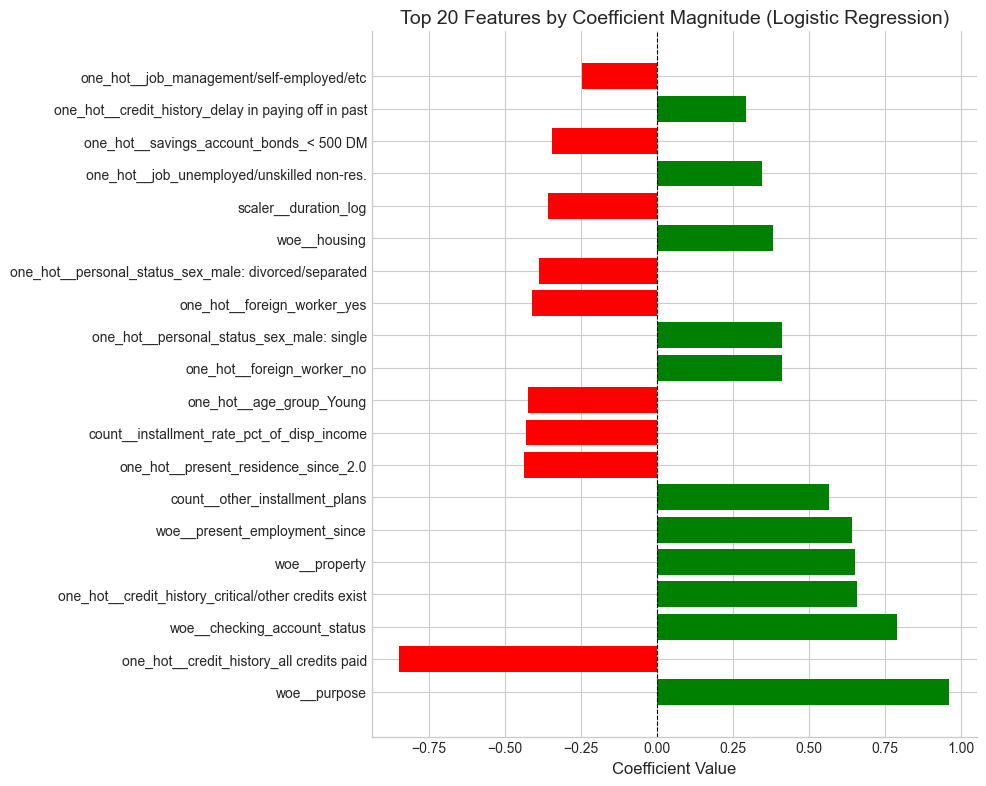

,feature,coefficient,abs_coefficient
26,woe__purpose,0.963243,0.963243
3,one_hot__credit_history_all credits paid,-0.845883,0.845883
25,woe__checking_account_status,0.790347,0.790347
1,one_hot__credit_history_critical/other credits...,0.658644,0.658644
28,woe__property,0.653583,0.653583
27,woe__present_employment_since,0.641455,0.641455
35,count__other_installment_plans,0.567926,0.567926
8,one_hot__present_residence_since_2.0,-0.437661,0.437661
34,count__installment_rate_pct_of_disp_income,-0.430447,0.430447
15,one_hot__age_group_Young,-0.421586,0.421586


In [19]:
# Get feature names and coefficients
basic_model_lrc.fit(X_train_processed_lrc, y_train)
feature_names = X_train_processed_lrc.columns
coefficients = basic_model_lrc.coef_[0]

# Create a dataframe with features and their coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features by Coefficient Magnitude:")
print("=" * 70)
print(f"{'Feature':<50} {'Coefficient':>15}")
print("-" * 70)
for idx, row in coef_df.head(15).iterrows():
    print(f"{row['feature']:<50} {row['coefficient']:>15.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_features = coef_df.head(20)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
ax.barh(range(len(top_features)), top_features['coefficient'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 20 Features by Coefficient Magnitude (Logistic Regression)')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

coef_df

<hr>

## Random Forest

In [22]:
from scripts.train_rf import rf_preprocess
from sklearn.ensemble import RandomForestClassifier

X_train_processed_rf, full_pipeline_rf = rf_preprocess(X_train, y_train)
X_train_processed_rf = pd.DataFrame(X_train_processed_rf)

basic_model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

basic_pipeline_rf = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_rf)
])

eng_pipeline_rf = Pipeline(steps=[
    ("full_pipeline", full_pipeline_rf),
    ("model", basic_model_rf)
])

basic_pipeline_rf.fit(X_train, y_train)
eng_pipeline_rf.fit(X_train, y_train)

X_train_processed_rf.shape, X_baseline.shape

((691, 42), (691, 61))

ROC AUC: 1.0000 ± 0.0000 (train), 0.7708 ± 0.0334 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


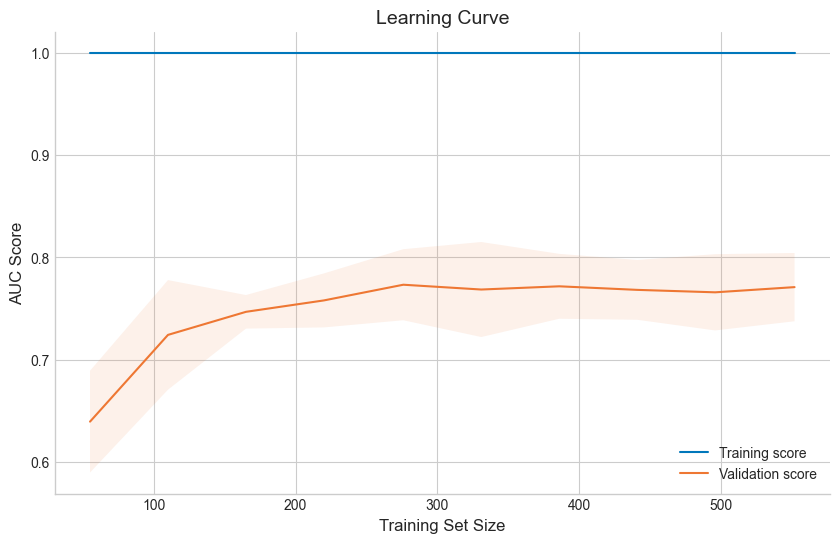

ROC AUC: 1.0000 ± 0.0000 (train), 0.7747 ± 0.0301 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


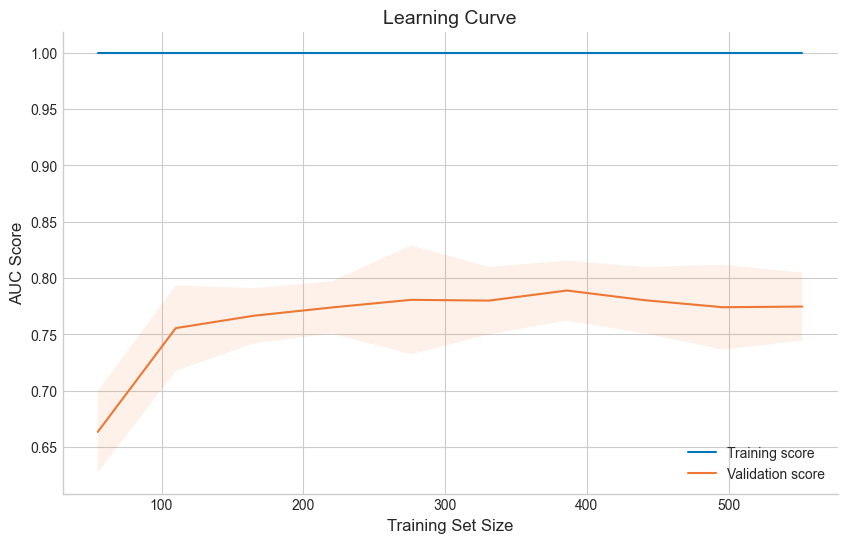

In [26]:
_ , res_rf_base = fn.plot_learning_curve(basic_model_rf, X_baseline, y_train)
_ , res_rf_eng = fn.plot_learning_curve(basic_model_rf, X_train_processed_rf, y_train)

In [27]:
diff = res_rf_eng['lc_val_auc_final'] - res_rf_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0039


In [23]:
basic_pipeline_rf = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_rf)
])

basic_pipeline_rf.fit(X_train, y_train)
fn.evaluate_model(X_val, y_val, basic_pipeline_rf, "Basic RF Pipeline")


────────────────────────────────────────
Evaluation Metrics for Basic RF Pipeline:
   ROC AUC:  0.7871
   Accuracy: 0.7533
   F1:       0.8398
   Precision:0.7760

   Total Cost: 149 | Avg Cost: 0.9933



{'roc_auc': 0.7870926243567753,
 'accuracy': 0.7533333333333333,
 'f1': 0.8398268398268398,
 'precision': 0.776,
 'cost': np.int64(149),
 'avg_cost': np.float64(0.9933333333333333)}

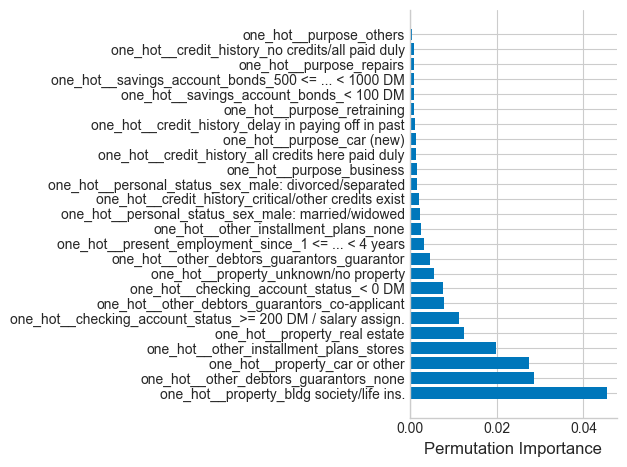

In [28]:
basic_model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
basic_model_rf.fit(X_train_processed_rf, y_train)

result = permutation_importance(
    basic_model_rf,
    X_train_processed_rf,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:25]
axes.barh(range(25), result.importances_mean[indices])
axes.set_yticks(range(25))
axes.set_yticklabels(X_baseline.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

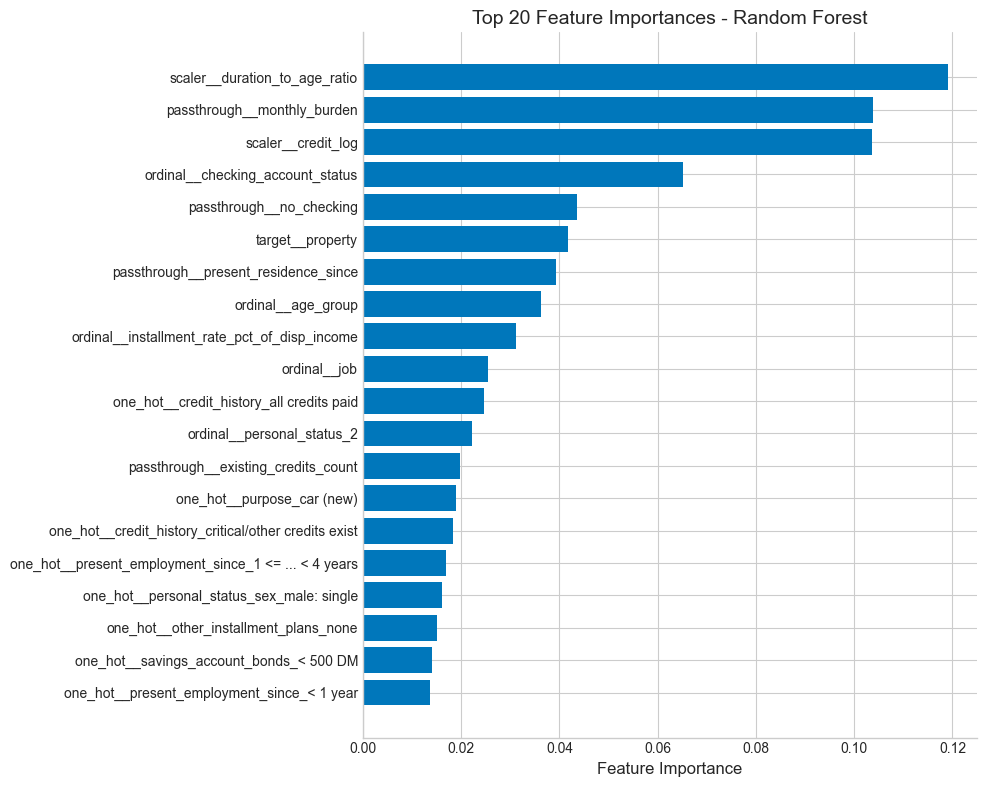


Top 10 Most Important Features:
scaler__duration_to_age_ratio                 0.1190
passthrough__monthly_burden                   0.1039
scaler__credit_log                            0.1036
ordinal__checking_account_status              0.0651
passthrough__no_checking                      0.0437
target__property                              0.0417
passthrough__present_residence_since          0.0393
ordinal__age_group                            0.0362
ordinal__installment_rate_pct_of_disp_income  0.0312
ordinal__job                                  0.0256


In [29]:
# Get feature importances from the trained model
feature_importances = basic_model_rf.feature_importances_
feature_names = X_train_processed_rf.columns

# Create a DataFrame for easier sorting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Feature Importances - Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTop 10 Most Important Features:")
print("=" * 60)
for idx, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:<45} {row['importance']:.4f}")

<hr>

### Feature engineering

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier

# Define models with vanilla configuration + random_state
# Note: CatBoost has sklearn compatibility issues, so we handle it separately
sklearn_models = [
    ('DummyClassifier', DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)),
    ('LogisticRegression', log_reg_tuned.best_estimator_),
    #('LogisticRegression', LogisticRegression(random_state=RANDOM_STATE)),
    ('SVC', svc_tuned.best_estimator_),
    #('SVC', SVC(probability=True, random_state=RANDOM_STATE)),
    ('RandomForest', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('XGBoost', xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0)),
]


# Handle CatBoost separately due to sklearn compatibility issues
print(f"\n{'─' * 40}")
print(f"📊 Training: CatBoost")
print(f"{'─' * 40}")

# Manual cross-validation for CatBoost
from sklearn.metrics import roc_auc_score, accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
catboost_roc_scores = []
catboost_acc_scores = []

for train_idx, val_idx in skf.split(train_df_enc, y_train):
    X_tr, X_val = train_df_enc.iloc[train_idx], train_df_enc.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    cb_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
    cb_model.fit(X_tr, y_tr)
    
    # ROC-AUC
    y_pred_proba = cb_model.predict_proba(X_val)[:, 1]
    catboost_roc_scores.append(roc_auc_score(y_val, y_pred_proba))
    
    # Accuracy
    y_pred = cb_model.predict(X_val)
    catboost_acc_scores.append(accuracy_score(y_val, y_pred))

catboost_roc_mean = np.mean(catboost_roc_scores)
catboost_roc_std = np.std(catboost_roc_scores)
catboost_acc_mean = np.mean(catboost_acc_scores)
catboost_acc_std = np.std(catboost_acc_scores)

print(f"   ROC-AUC:  {catboost_roc_mean:.4f} ± {catboost_roc_std:.4f}")
print(f"   Accuracy: {catboost_acc_mean:.4f} ± {catboost_acc_std:.4f}")

results.append({
    'Model': 'CatBoost',
    'ROC-AUC Mean': catboost_roc_mean,
    'ROC-AUC Std': catboost_roc_std,
    'Accuracy Mean': catboost_acc_mean,
    'Accuracy Std': catboost_acc_std
})

# Fit final CatBoost model and plot learning curve manually
catboost_final = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
catboost_final.fit(train_df_enc, y_train)

# Manual learning curve for CatBoost
print(f"\n   📈 Learning Curve:")
train_sizes_pct = np.linspace(0.1, 1.0, 10)
train_scores_cb = []
val_scores_cb = []

for train_size in train_sizes_pct:
    fold_train_scores = []
    fold_val_scores = []
    
    for train_idx, val_idx in skf.split(train_df_enc, y_train):
        # Subsample training data
        n_samples = int(len(train_idx) * train_size)
        train_idx_subset = train_idx[:n_samples]
        
        X_tr = train_df_enc.iloc[train_idx_subset]
        y_tr = y_train.iloc[train_idx_subset]
        X_val = train_df_enc.iloc[val_idx]
        y_val = y_train.iloc[val_idx]
        
        cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
        cb.fit(X_tr, y_tr)
        
        # Training score
        fold_train_scores.append(roc_auc_score(y_tr, cb.predict_proba(X_tr)[:, 1]))
        # Validation score
        fold_val_scores.append(roc_auc_score(y_val, cb.predict_proba(X_val)[:, 1]))
    
    train_scores_cb.append(fold_train_scores)
    val_scores_cb.append(fold_val_scores)

train_scores_cb = np.array(train_scores_cb)
val_scores_cb = np.array(val_scores_cb)
train_sizes_abs = (train_sizes_pct * len(train_df_enc) * 0.8).astype(int)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes_abs, train_scores_cb.mean(axis=1), label='Training Score', color='blue')
ax.plot(train_sizes_abs, val_scores_cb.mean(axis=1), label='Validation Score', color='orange')
ax.fill_between(train_sizes_abs, 
                train_scores_cb.mean(axis=1) - train_scores_cb.std(axis=1),
                train_scores_cb.mean(axis=1) + train_scores_cb.std(axis=1), 
                alpha=0.1, color='blue')
ax.fill_between(train_sizes_abs, 
                val_scores_cb.mean(axis=1) - val_scores_cb.std(axis=1),
                val_scores_cb.mean(axis=1) + val_scores_cb.std(axis=1), 
                alpha=0.1, color='orange')
ax.set_xlabel('Training Size')
ax.set_ylabel('Roc_auc')
ax.set_title('Learning Curve for CatBoostClassifier')
ax.legend(loc='best')
ax.grid()
plt.show()

# Create results DataFrame
print("\n" + "=" * 80)
print("📋 RESULTS SUMMARY TABLE")
print("=" * 80)

results_df = pd.DataFrame(results)
results_df['ROC-AUC'] = results_df.apply(lambda x: f"{x['ROC-AUC Mean']:.4f} ± {x['ROC-AUC Std']:.4f}", axis=1)
results_df['Accuracy'] = results_df.apply(lambda x: f"{x['Accuracy Mean']:.4f} ± {x['Accuracy Std']:.4f}", axis=1)

# Sort by ROC-AUC Mean descending
results_df = results_df.sort_values('ROC-AUC Mean', ascending=False).reset_index(drop=True)

# Display clean table
display_df = results_df[['Model', 'ROC-AUC', 'Accuracy']].copy()
display_df.index = range(1, len(display_df) + 1)
display_df.index.name = 'Rank'

print(display_df.to_string())

# Highlight best model
best_model = results_df.iloc[0]['Model']
best_roc_auc = results_df.iloc[0]['ROC-AUC Mean']
print(f"\n🏆 Best Model: {best_model} (ROC-AUC: {best_roc_auc:.4f})")

# Store for later use
results_df

In [29]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


svc_space = {
                    'C': Real(0.1, 15, prior='log-uniform'),
                    'gamma': Real(1e-3, 1, prior='log-uniform'),
                    'kernel': Categorical(['rbf', 'linear']),
                    'tol': Real(1e-4, 1e-1, prior='log-uniform'),
                    'class_weight': Categorical(['balanced', None])
                }


log_reg_space = {
    'penalty': Categorical(['l2']),
    'C': Real(0.01, 20, prior='log-uniform'),
    'solver': Categorical(['liblinear']),
    'max_iter': Integer(1000, 8000),

}



ran_forest_space = {
                    'n_estimators': Integer(100, 500),
                    'max_depth': Integer(5, 30),
                    'min_samples_split': Integer(2, 20),
                    'min_samples_leaf': Integer(1, 10),
                    'max_features': Categorical(['sqrt', 'log2', None]),
                }


In [30]:
svc_tuned = BayesSearchCV(
    estimator=SVC(probability=True, random_state=RANDOM_STATE),
    search_spaces=svc_space,
    n_iter=25,
    scoring='roc_auc',
    cv=8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    n_points=5
)
log_reg_tuned = BayesSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    search_spaces=log_reg_space,
    n_iter=25,
    scoring='roc_auc',
    cv=8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    n_points=5
)


rf_tuned = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    search_spaces=ran_forest_space,
    n_iter=25,
    scoring='roc_auc',
    cv=8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    n_points=5
)


In [ ]:
cat_boost_space = {
    'depth': Integer(4,10),
    'iterations': Integer(100, 400),
    'learning_rate': Real(0.01, 0.2, prior='uniform'),
}

cat_boost_tuned = BayesSearchCV(
    estimator=CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    search_spaces=cat_boost_space,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

In [36]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=FutureWarning)

for model in [svc_tuned, log_reg_tuned]:
        scores = cross_val_score(model, train_df_enc, y_train, cv=5, scoring='roc_auc')
        print(f"{model.__class__.__name__} AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

NameError: name 'cross_val_score' is not defined

In [54]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=FutureWarning)

_ = log_reg_tuned.fit(X_train_processed_lrc, y_train)


/Users/fotisn/.local/share/uv/python/cpython-3.13.9-macos-aarch64-none/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/fotisn/.local/share/uv/python/cpython-3.13.9-macos-aarch64-none/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/fotisn/.local/share/uv/python/cpython-3.13.9-macos-aarch64-none/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/

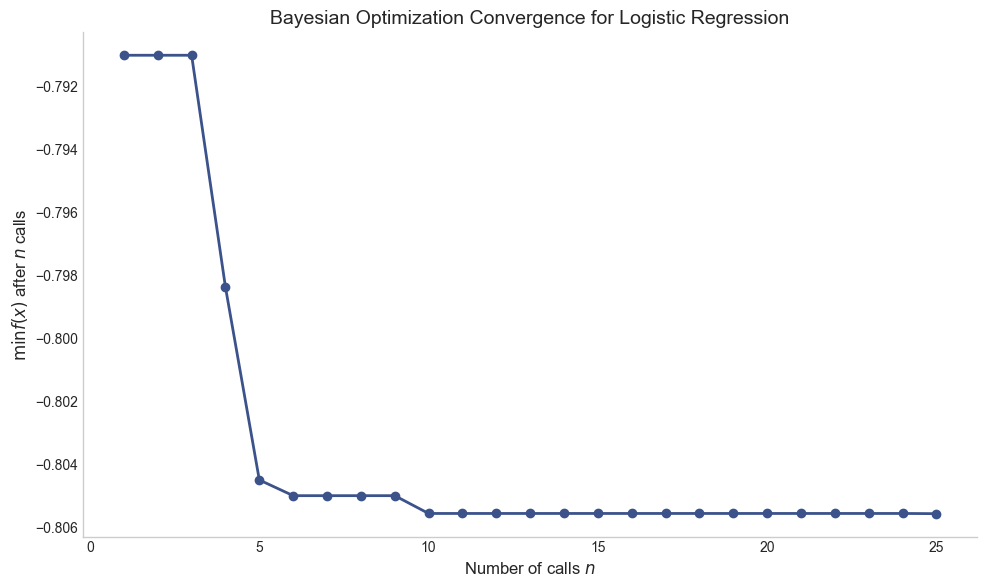

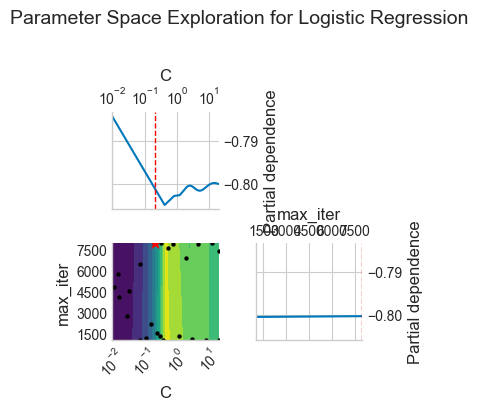

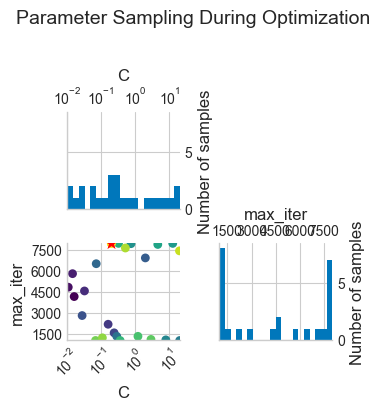


Best ROC-AUC Score: 0.8056

Best Parameters:
  C: 0.20257899368793866
  max_iter: 8000
  penalty: l2
  solver: liblinear


In [57]:
from skopt.plots import plot_objective, plot_evaluations, plot_convergence

import matplotlib.pyplot as plt

# Plot convergence - shows how the optimization improved over iterations
fig, ax = plt.subplots(figsize=(10, 6))
plot_convergence(log_reg_tuned.optimizer_results_[0])
plt.title('Bayesian Optimization Convergence for Logistic Regression', fontsize=14)
plt.tight_layout()
plt.show()

# Plot objective function - shows parameter importance and interactions
fig = plot_objective(log_reg_tuned.optimizer_results_[0], 

                     n_points=50)
plt.suptitle('Parameter Space Exploration for Logistic Regression', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Plot evaluations - shows how parameters were sampled during optimization
fig = plot_evaluations(log_reg_tuned.optimizer_results_[0])

plt.suptitle('Parameter Sampling During Optimization', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print best parameters and score
print(f"\nBest ROC-AUC Score: {log_reg_tuned.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in log_reg_tuned.best_params_.items():
    print(f"  {param}: {value}")

In [33]:
svc_tuned.score(X_train_processed_svc, y_train)

0.9956492772349188

In [20]:
log_reg_tuned.fit(train_df_enc, y_train)

/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty'

,estimator,LogisticRegre...andom_state=8)
,search_spaces,"{'C': Real(low=0.01...m='normalize'), 'max_iter': Integer(low=1...m='normalize'), 'penalty': Categorical(c...), prior=None), 'solver': Categorical(c...), prior=None)}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [ ]:
import pickle

# Save the best estimators
with open('svc_tuned_model.pkl', 'wb') as f:
    pickle.dump(svc_tuned.best_estimator_, f)

with open('log_reg_tuned_model.pkl', 'wb') as f:
    pickle.dump(log_reg_tuned.best_estimator_, f)

with open('xgb_tuned_model.pkl', 'wb') as f:
    pickle.dump(xgb_tuned.best_estimator_, f)

print("Models saved successfully!")

# Extract best estimators for evaluation
svc_t = svc_tuned.best_estimator_
log_reg_t = log_reg_tuned.best_estimator_
xgboost_t = xgb_tuned.best_estimator_

for dataset in sets:
    print(f"Dataset shape: {dataset.shape}")
    for model in [svc_t, log_reg_t, xgboost_t]:
        scores = cross_val_score(model, dataset, y_train, cv=5, scoring='roc_auc')
        print(f"{model.__class__.__name__} AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    print("-" * 40)

Dataset shape: (700, 36)
SVC AUC: 0.7807 ± 0.0322
LogisticRegression AUC: 0.7863 ± 0.0106


/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty'

XGBClassifier AUC: 0.7990 ± 0.0294
----------------------------------------


In [97]:
import pickle
# Save the best estimators
with open('svc_tuned_model.pkl', 'wb') as f:
    pickle.dump(svc_tuned.best_estimator_, f)

with open('log_reg_tuned_model.pkl', 'wb') as f:
    pickle.dump(log_reg_tuned.best_estimator_, f)

with open('xgb_tuned_model.pkl', 'wb') as f:
    pickle.dump(xgb_tuned.best_estimator_, f)

print("Models saved successfully!")


Models saved successfully!


In [4]:
import pickle
# Load the models
with open('svc_tuned_model.pkl', 'rb') as f:
    svc_t = pickle.load(f)
with open('log_reg_tuned_model.pkl', 'rb') as f:
    log_reg_t = pickle.load(f)
with open('xgb_tuned_model.pkl', 'rb') as f:
    xgboost_t = pickle.load(f)

In [21]:
def check_feature_target_correlation(X, y, method='auto'):
    """
    Check correlation between features and target variable.
    Handles both numeric and categorical features appropriately.
    
    Parameters:
    -----------
    X : pd.DataFrame - Feature matrix
    y : pd.Series - Target variable
    method : str - Correlation method:
        - 'auto': Automatically choose based on feature type
        - 'point_biserial': For numeric features with binary target
        - 'cramers_v': For categorical features with categorical target
    
    Returns:
    --------
    pd.DataFrame - Correlations sorted by absolute value
    """
    from scipy.stats import pointbiserialr, chi2_contingency
    
    def cramers_v(x, y):
        """Calculate Cramér's V statistic for categorical-categorical association."""
        contingency_table = pd.crosstab(x, y)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        if min_dim == 0:
            return 0, p_value
        v = np.sqrt(chi2 / (n * min_dim))
        return v, p_value
    
    correlations = []
    
    for col in X.columns:
        try:
            # Check if column is numeric
            if pd.api.types.is_numeric_dtype(X[col]):
                # Use point-biserial for numeric features
                # Drop NaN values for calculation
                mask = ~(X[col].isna() | y.isna())
                corr, p_value = pointbiserialr(y[mask], X[col][mask])
                method_used = 'point_biserial'
            else:
                # Use Cramér's V for categorical features
                corr, p_value = cramers_v(X[col].astype(str), y)
                method_used = 'cramers_v'
            
            correlations.append({
                'feature': col,
                'correlation': corr,
                'abs_correlation': abs(corr),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'method': method_used,
                'dtype': str(X[col].dtype)
            })
        except Exception as e:
            print(f"⚠️ Could not calculate correlation for '{col}': {e}")
            correlations.append({
                'feature': col,
                'correlation': np.nan,
                'abs_correlation': np.nan,
                'p_value': np.nan,
                'significant': False,
                'method': 'error',
                'dtype': str(X[col].dtype)
            })
    
    # Create DataFrame and sort by absolute correlation
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    
    # Print results
    print("=" * 85)
    print(f"FEATURE-TARGET CORRELATION ANALYSIS")
    print("=" * 85)
    print(f"\n{'Feature':<30} {'Correlation':>10} {'P-value':>10} {'Sig?':>6} {'Method':>15}")
    print("-" * 85)
    
    for _, row in corr_df.iterrows():
        sig_marker = "✓" if row['significant'] else "✗"
        corr_val = f"{row['correlation']:.4f}" if pd.notna(row['correlation']) else "N/A"
        p_val = f"{row['p_value']:.4f}" if pd.notna(row['p_value']) else "N/A"
        print(f"{row['feature']:<30} {corr_val:>10} {p_val:>10} {sig_marker:>6} {row['method']:>15}")
    
    # Summary
    print("\n" + "=" * 85)
    print("SUMMARY")
    print("=" * 85)
    
    valid_corr = corr_df[corr_df['abs_correlation'].notna()]
    strong = valid_corr[valid_corr['abs_correlation'] >= 0.3]
    moderate = valid_corr[(valid_corr['abs_correlation'] >= 0.1) & (valid_corr['abs_correlation'] < 0.3)]
    weak = valid_corr[valid_corr['abs_correlation'] < 0.1]
    
    print(f"\n📊 Methods used:")
    print(f"   • Point-biserial (numeric features): {len(corr_df[corr_df['method'] == 'point_biserial'])}")
    print(f"   • Cramér's V (categorical features): {len(corr_df[corr_df['method'] == 'cramers_v'])}")
    
    print(f"\n🔴 Strong correlation (|r| >= 0.3): {len(strong)} features")
    if len(strong) > 0:
        print(f"   → {', '.join(strong['feature'].tolist())}")
    
    print(f"🟡 Moderate correlation (0.1 <= |r| < 0.3): {len(moderate)} features")
    if len(moderate) > 0:
        print(f"   → {', '.join(moderate['feature'].tolist())}")
    
    print(f"🟢 Weak correlation (|r| < 0.1): {len(weak)} features")
    
    not_significant = corr_df[~corr_df['significant'] & corr_df['p_value'].notna()]
    if len(not_significant) > 0:
        print(f"\n⚠️ Non-significant correlations (p >= 0.05): {len(not_significant)}")
        print(f"   → {', '.join(not_significant['feature'].tolist())}")
    
    return corr_df


def check_multicollinearity(X, threshold=0.7, vif_threshold=5.0):
    """
    Check multicollinearity between features using correlation matrix and VIF.
    
    Parameters:
    -----------
    X : pd.DataFrame - Feature matrix (numeric columns only)
    threshold : float - Correlation threshold to flag high correlation (default: 0.7)
    vif_threshold : float - VIF threshold to flag multicollinearity (default: 5.0)
    
    Returns:
    --------
    dict - Dictionary with correlation pairs and VIF values
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Select only numeric columns
    numeric_X = X.select_dtypes(include=[np.number])
    
    print("=" * 70)
    print("MULTICOLLINEARITY ANALYSIS")
    print("=" * 70)
    
    if len(numeric_X.columns) == 0:
        print("\n⚠️ No numeric columns found in the dataset!")
        return {'high_correlation_pairs': None, 'vif_scores': None, 'features_to_drop': []}
    
    print(f"\n📌 Analyzing {len(numeric_X.columns)} numeric features")
    
    # 1. Correlation Matrix Analysis
    print(f"\n📊 CORRELATION ANALYSIS (threshold: |r| >= {threshold})")
    print("-" * 70)
    
    corr_matrix = numeric_X.corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        high_corr_df = high_corr_df.sort_values('correlation', key=abs, ascending=False)
        
        print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs:\n")
        print(f"{'Feature 1':<25} {'Feature 2':<25} {'Correlation':>12}")
        print("-" * 65)
        for _, row in high_corr_df.iterrows():
            print(f"{row['feature_1']:<25} {row['feature_2']:<25} {row['correlation']:>12.4f}")
    else:
        print(f"✅ No feature pairs with correlation >= {threshold}")
        high_corr_df = pd.DataFrame()
    
    # 2. Variance Inflation Factor (VIF) Analysis
    print(f"\n📊 VIF ANALYSIS (threshold: VIF >= {vif_threshold})")
    print("-" * 70)
    
    # Handle potential issues with VIF calculation
    try:
        # Remove constant columns and handle NaN
        X_clean = numeric_X.dropna()
        X_clean = X_clean.loc[:, X_clean.std() > 0]  # Remove zero-variance columns
        
        if len(X_clean.columns) > 1:
            vif_data = []
            for i, col in enumerate(X_clean.columns):
                try:
                    vif = variance_inflation_factor(X_clean.values, i)
                    vif_data.append({'feature': col, 'VIF': vif})
                except Exception as e:
                    vif_data.append({'feature': col, 'VIF': np.nan})
            
            vif_df = pd.DataFrame(vif_data)
            vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)
            
            print(f"\n{'Feature':<35} {'VIF':>12} {'Status':>15}")
            print("-" * 65)
            
            for _, row in vif_df.iterrows():
                if pd.isna(row['VIF']):
                    status = "⚠️ Error"
                elif row['VIF'] >= 10:
                    status = "🔴 High"
                elif row['VIF'] >= vif_threshold:
                    status = "🟡 Moderate"
                else:
                    status = "🟢 OK"
                print(f"{row['feature']:<35} {row['VIF']:>12.2f} {status:>15}")
            
            high_vif = vif_df[vif_df['VIF'] >= vif_threshold]
        else:
            print("⚠️ Not enough features to calculate VIF")
            vif_df = pd.DataFrame()
            high_vif = pd.DataFrame()
    except Exception as e:
        print(f"⚠️ Error calculating VIF: {e}")
        vif_df = pd.DataFrame()
        high_vif = pd.DataFrame()
    
    # 3. Recommendations
    print("\n" + "=" * 70)
    print("RECOMMENDATIONS")
    print("=" * 70)
    
    features_to_drop = set()
    
    # Based on correlation
    if len(high_corr_pairs) > 0:
        print("\n📌 Based on HIGH CORRELATION:")
        for pair in high_corr_pairs:
            f1, f2 = pair['feature_1'], pair['feature_2']
            print(f"   • Consider dropping one of: '{f1}' or '{f2}' (r = {pair['correlation']:.4f})")
            # Suggest dropping the one with lower variance (less information)
            if numeric_X[f1].std() < numeric_X[f2].std():
                features_to_drop.add(f1)
                print(f"     → Suggestion: Drop '{f1}' (lower variance)")
            else:
                features_to_drop.add(f2)
                print(f"     → Suggestion: Drop '{f2}' (lower variance)")
    
    # Based on VIF
    if len(high_vif) > 0:
        print("\n📌 Based on HIGH VIF:")
        for _, row in high_vif.iterrows():
            print(f"   • '{row['feature']}' has VIF = {row['VIF']:.2f}")
            features_to_drop.add(row['feature'])
    
    if features_to_drop:
        print(f"\n🎯 SUGGESTED FEATURES TO DROP: {list(features_to_drop)}")
        print(f"\n   Code to drop: X = X.drop(columns={list(features_to_drop)})")
    else:
        print("\n✅ No multicollinearity issues detected!")
    
    return {
        'high_correlation_pairs': high_corr_df if len(high_corr_pairs) > 0 else None,
        'vif_scores': vif_df if len(vif_df) > 0 else None,
        'features_to_drop': list(features_to_drop)
    }

In [26]:
temp_df = X_train_processed.iloc[:, 18:]
temp_df.head()

,monthly_burden,credit_to_age_ratio,duration_to_age_ratio,age_times_credit,existing_credits_times_credit,credit_to_age_ratio_log,duration_to_age_ratio_sqrt,age_times_credit_log,existing_credits_times_credit_log,credit_log,duration_log,monthly_burden_log,duration_bins,credit_to_age_ratio_bins,duration_to_age_ratio_bins,age_times_credit_bins,existing_credits_times_credit_bins,credit_amount_bins,age_group
237,81.916667,51.736842,0.631579,18677,983,3.965314,0.794719,9.835102,6.891626,6.891626,2.564949,4.405702,very_short,low,medium,very_low,very_low,a,Young
278,355.000000,108.472222,0.305556,140580,7810,4.695671,0.552771,11.853539,8.963288,8.270269,2.484907,5.872118,very_short,high,low,high,medium,b,Prime
482,206.444444,137.629630,0.666667,401328,7432,4.931806,0.816497,12.902537,8.913685,8.913685,3.610918,5.330031,very_long,high,high,very_high,medium,d,Prime
238,326.166667,63.129032,0.193548,60667,1957,4.160897,0.439941,11.013172,7.579679,7.579679,1.945910,5.787408,very_short,medium,very_low,low,very_low,a,Early_Career
732,56.583333,33.950000,0.600000,54320,1358,3.553918,0.774597,10.902666,7.214504,7.214504,3.218876,4.035714,long,very_low,medium,low,very_low,a,Prime


In [27]:
check_feature_target_correlation(temp_df, y_train)

FEATURE-TARGET CORRELATION ANALYSIS

Feature                        Correlation    P-value   Sig?          Method
-------------------------------------------------------------------------------------
duration_to_age_ratio_bins         0.2560     0.0000      ✓       cramers_v
duration_to_age_ratio_sqrt        -0.2436     0.0000      ✓  point_biserial
duration_to_age_ratio             -0.2310     0.0000      ✓  point_biserial
duration_log                      -0.2237     0.0000      ✓  point_biserial
duration_bins                      0.2197     0.0000      ✓       cramers_v
age_group                          0.1641     0.0003      ✓       cramers_v
credit_amount_bins                 0.1439     0.0064      ✓       cramers_v
credit_to_age_ratio_log           -0.1401     0.0002      ✓  point_biserial
age_times_credit_bins              0.1386     0.0100      ✓       cramers_v
credit_to_age_ratio               -0.1385     0.0003      ✓  point_biserial
existing_credits_times_credit_bins     0

,feature,correlation,abs_correlation,p_value,significant,method,dtype
0,duration_to_age_ratio_bins,0.255952,0.255952,3.496422e-09,True,cramers_v,category
1,duration_to_age_ratio_sqrt,-0.243608,0.243608,8.576200e-11,True,point_biserial,float64
2,duration_to_age_ratio,-0.231034,0.231034,7.971245e-10,True,point_biserial,float64
3,duration_log,-0.223677,0.223677,2.771333e-09,True,point_biserial,float64
4,duration_bins,0.219731,0.219731,1.006689e-06,True,cramers_v,category
5,age_group,0.164058,0.164058,3.309956e-04,True,cramers_v,category
6,credit_amount_bins,0.143902,0.143902,6.371156e-03,True,cramers_v,category
7,credit_to_age_ratio_log,-0.140131,0.140131,2.197206e-04,True,point_biserial,float64
8,age_times_credit_bins,0.138559,0.138559,1.004596e-02,True,cramers_v,category
9,credit_to_age_ratio,-0.138484,0.138484,2.608785e-04,True,point_biserial,float64


In [29]:

check_multicollinearity(temp_df.drop(columns=['credit_to_age_ratio', 'existing_credits_times_credit'
                                              ,'age_times_credit', 'existing_credits_times_credit_log',
                                              'age_times_credit_log', 'credit_to_age_ratio_log']), threshold=0.7, vif_threshold=5.0)

MULTICOLLINEARITY ANALYSIS

📌 Analyzing 6 numeric features

📊 CORRELATION ANALYSIS (threshold: |r| >= 0.7)
----------------------------------------------------------------------

⚠️ Found 4 highly correlated feature pairs:

Feature 1                 Feature 2                  Correlation
-----------------------------------------------------------------
duration_to_age_ratio     duration_to_age_ratio_sqrt       0.9782
duration_to_age_ratio_sqrt duration_log                    0.8882
duration_to_age_ratio     duration_log                    0.8395
monthly_burden            monthly_burden_log              0.8250

📊 VIF ANALYSIS (threshold: VIF >= 5.0)
----------------------------------------------------------------------

Feature                                      VIF          Status
-----------------------------------------------------------------
credit_log                             135830.95          🔴 High
monthly_burden_log                      49877.14          🔴 High
duration_l

{'high_correlation_pairs':                     feature_1                   feature_2  correlation
 1       duration_to_age_ratio  duration_to_age_ratio_sqrt     0.978154
 3  duration_to_age_ratio_sqrt                duration_log     0.888225
 2       duration_to_age_ratio                duration_log     0.839479
 0              monthly_burden          monthly_burden_log     0.825036,
 'vif_scores':                       feature            VIF
 0                  credit_log  135830.949087
 1          monthly_burden_log   49877.143317
 2                duration_log   21679.337495
 3  duration_to_age_ratio_sqrt     338.603127
 4       duration_to_age_ratio      70.080437
 5              monthly_burden       6.745830,
 'features_to_drop': ['duration_log',
  'credit_log',
  'monthly_burden_log',
  'duration_to_age_ratio',
  'duration_to_age_ratio_sqrt',
  'monthly_burden']}

In [28]:
check_multicollinearity(X_train_processed_rf)

MULTICOLLINEARITY ANALYSIS

📌 Analyzing 50 numeric features

📊 CORRELATION ANALYSIS (threshold: |r| >= 0.7)
----------------------------------------------------------------------

⚠️ Found 9 highly correlated feature pairs:

Feature 1                 Feature 2                  Correlation
-----------------------------------------------------------------
one_hot__housing_not_own  one_hot__housing_own           -1.0000
one_hot__checking_account_status_no checking account target__checking_3              0.9100
one_hot__duration_bins_very_long scaler__duration_months         0.8132
one_hot__checking_account_status_no checking account count__checking_2               0.8102
one_hot__credit_amount_bins_a scaler__credit_log             -0.8046
one_hot__savings_account_bonds_< 500 DM one_hot__savings_account_bonds_unknown/no savings account      -0.7500
one_hot__checking_account_status_>= 200 DM / salary assign. count__checking_2              -0.7397
one_hot__checking_account_status_< 0 DM targ

/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


{'high_correlation_pairs':                                            feature_1  \
 5                           one_hot__housing_not_own   
 2  one_hot__checking_account_status_no checking a...   
 6                   one_hot__duration_bins_very_long   
 1  one_hot__checking_account_status_no checking a...   
 7                      one_hot__credit_amount_bins_a   
 4            one_hot__savings_account_bonds_< 500 DM   
 3  one_hot__checking_account_status_>= 200 DM / s...   
 0            one_hot__checking_account_status_< 0 DM   
 8  one_hot__personal_status_sex_female: div/sep/m...   
 
                                            feature_2  correlation  
 5                               one_hot__housing_own    -1.000000  
 2                                 target__checking_3     0.910019  
 6                            scaler__duration_months     0.813212  
 1                                  count__checking_2     0.810155  
 7                                 scaler__credit_log    

<hr>

In [ ]:
# After final model selection, check stability:

final_model = CatBoostClassifier(**best_params)

# Test across multiple seeds to report uncertainty
seed_results = []
for seed in [42, 123, 456, 789, 999]:
    model = final_model.set_params(random_state=seed)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    seed_results.append(cv_score.mean())

print(f"Mean AUC: {np.mean(seed_results):.4f}")
print(f"Std AUC: {np.std(seed_results):.4f}")
print(f"Range: [{np.min(seed_results):.4f}, {np.max(seed_results):.4f}]")

# Expected for 700 samples:
# Std ~0.01-0.02 (1-2% variation)
# This is just reporting stability, not model selection

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder, WOEEncoder
import pandas as pd
import numpy as np


stom transformer for feature engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer for creating new features and transforming existing ones."""
    
    def __init__(self):
        self.cols_to_drop = [
            "other_debtors_guarantors",
            "telephone",
            "foreign_worker",
            "present_residence_since",
            "existing_credits_count",
            "people_liable_for_maintenance",
            "installment_rate_pct_of_disp_income",
            "personal_status_sex"
        ]
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Drop unnecessary columns (only if they exist)
        cols_to_drop_existing = [c for c in self.cols_to_drop if c in X.columns]
        X = X.drop(columns=cols_to_drop_existing)
        
        # Create new features
        X['duration_squared'] = X['duration_months'] ** 2
        X['monthly_burden'] = X['credit_amount'] / X['duration_months']
        
        # Merge purpose categories
        X['purpose'] = X['purpose'].replace(
            ['education', 'retraining'], 'personal_development'
        )
        X['purpose'] = X['purpose'].replace(
            ['domestic appliances', 'repairs', 'others'], 'home_improvement'
        )
        
        # Bin credit amount
        X['credit_amount_bins'] = pd.cut(
            X['credit_amount'],
            bins=[0, 2000, 4000, 7000, 10000, 50000],
            labels=['a', 'b', 'c', 'd', 'e']
        )
        
        # Merge savings categories
        X['savings_account_bonds'] = X['savings_account_bonds'].replace(
            ['< 100 DM', '100 <= ... < 500 DM'], '< 500 DM'
        )
        X['savings_account_bonds'] = X['savings_account_bonds'].replace(
            ['500 <= ... < 1000 DM', '>= 1000 DM'], '>= 500 DM'
        )
        
        # Create age groups
        X['age_group'] = pd.cut(
            X['age_years'],
            bins=[0, 25, 35, 50, 65, 100],
            labels=['Young', 'Early_Career', 'Prime', 'Mature', 'Senior']
        )
        
        # Drop original columns that were transformed
        X = X.drop(columns=['duration_months', 'credit_amount', 'age_years'])
        
        return X
# Cu

# Define column groups for encoding
one_hot_cols = [
    'credit_history',
    'purpose',
    'credit_amount_bins',
    'property',
    'housing',
]

woe_cols = [
    'checking_account_status',
    'savings_account_bonds',
    'present_employment_since',
    'age_group',
    'other_installment_plans',
    'job'
]

numeric_cols = [
    'duration_squared',
    'monthly_burden',
]


# Create the encoding pipeline
encoding_pipeline = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(cols=one_hot_cols, use_cat_names=True), one_hot_cols),
        ('woe', WOEEncoder(cols=woe_cols), woe_cols),
        ('scaler', StandardScaler(), numeric_cols)
    ],
    remainder='drop'  # or 'passthrough' if you want to keep other columns
)


# Full pipeline combining feature engineering + encoding
full_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('encoder', encoding_pipeline)
])





<hr>

## Model training

### Training functions

In [51]:
from sklearn.model_selection import cross_val_score

def train_model(model, X_train, y_train, random_state=6, tracking=True, log_learning_curve=True, cv=5, tag=None, **config):
    """Train model with optional MLflow tracking and learning curve logging.
    
    Parameters:
    -----------
    model : estimator - Model to train
    X_train : array-like - Training features
    y_train : array-like - Training target
    random_state : int - Random state for reproducibility
    tracking : bool - Whether to log to MLflow
    log_learning_curve : bool - Whether to generate and log learning curve plot
    cv : int - Number of cross-validation folds for learning curve
    **config : dict - Model hyperparameters
    
    Returns:
    --------
    model : trained estimator
    """
    model.set_params(**config)

    if tracking:
        with mlflow.start_run(run_name=model.__class__.__name__):
            
            mlflow.set_tag('dataset', tag)
            model.fit(X_train, y_train)

            mlflow.log_params(config)
            mlflow.log_param('dataset_shape', X_train.shape)

            mlflow.log_param('model_type', model.__class__.__name__)
            # Train the model
            model.fit(X_train, y_train)
            print(f'Training dataset: {tag}')  
            # Make predictions on training data
            y_pred = model.predict(X_train)
            
            # Calculate metrics
            cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
            roc_auc = np.mean(cross_val_scores)
            cross_val_scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
            f1 = np.mean(cross_val_scores_f1)
            
            # Log metrics to MLflow
            #mlflow.log_metrics({"roc_auc": roc_auc, "f1": f1})
            
            print(f"Training scores: ROC AUC={roc_auc:.4f},  F1={f1:.4f}")
            
            # Generate and log learning curve
            if log_learning_curve:
                print(f"Generating learning curve for {model.__class__.__name__}...")
                fig = plot_learning_curve(model, X_train, y_train, cv=cv, scoring='roc_auc', return_fig=True)
                
                # Save figure to temporary file and log to MLflow
                with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
                    fig.savefig(tmp.name, dpi=100, bbox_inches='tight')
                    mlflow.log_artifact(tmp.name, artifact_path="plots")
                    os.unlink(tmp.name)  # Clean up temp file
                plt.close(fig)
                print(f"Learning curve logged to MLflow")
            
            return model
    else:
        model.fit(X_train, y_train)
        # Make predictions on training data
        y_pred = model.predict(X_train)
        print(f'Training dataset: {tag}')    
        # Calculate metrics
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        roc_auc = np.mean(cross_val_scores)
        cross_val_scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        f1 = np.mean(cross_val_scores_f1)
        print(f"Training scores: ROC AUC={roc_auc:.4f}, F1={f1:.4f}")
        plot_learning_curve(model, X_train, y_train, cv=cv, scoring='roc_auc')
        return model


### Baseline models

set experiment tracking 

In [ ]:
mlflow.set_tracking_uri("file://" + str(home / "mlruns"))
mlflow.set_experiment('credit_risk-baseline_1')

Exception: Invalid parent directory '/Users/fotisn/code/repos/credit-risk-svm/mlruns/.trash'

Training dataset: svc set 2
Training scores: ROC AUC=0.7868, F1=0.8527


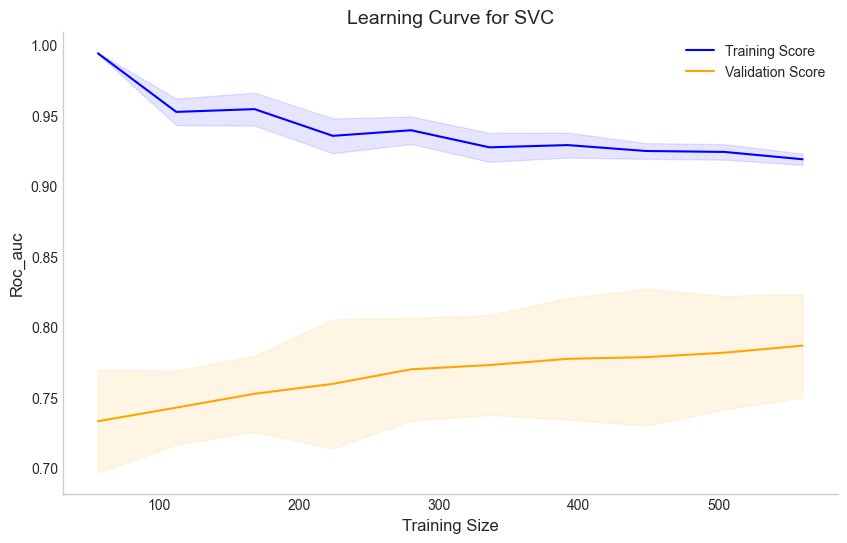

Training dataset: log reg set 2
Training scores: ROC AUC=0.7807, F1=0.8330


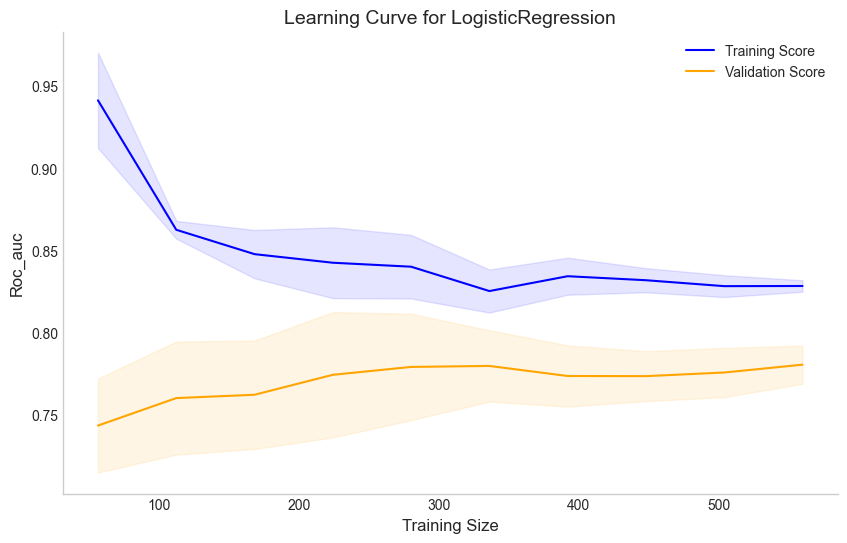

Training dataset: rand forest set 2
Training scores: ROC AUC=0.7810, F1=0.8660
Training scores: ROC AUC=0.7810, F1=0.8660


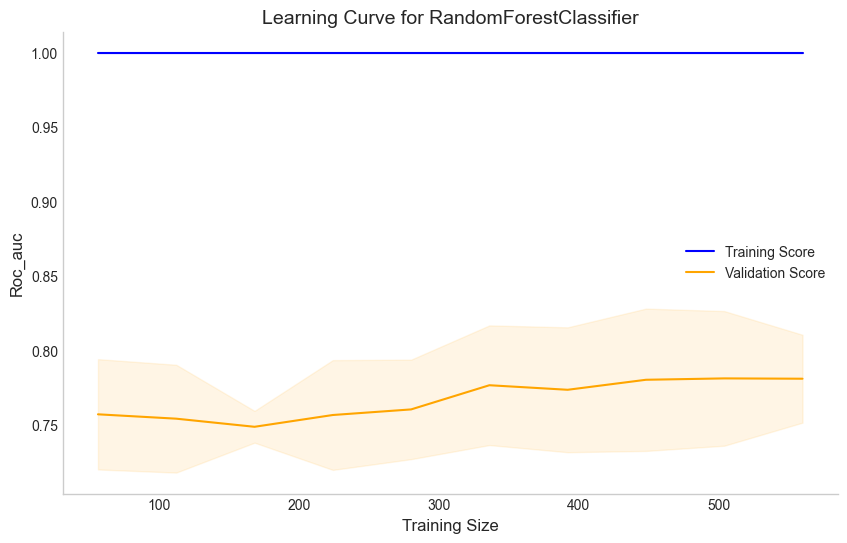

In [70]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#svc_1 = train_model(SVC(random_state=RANDOM_STATE), train_df_enc_1, y_train, tag='svc set 1', tracking=False, random_state=RANDOM_STATE)
svc_2 = train_model(SVC(random_state=RANDOM_STATE), train_df_enc_2, y_train, tag='svc set 2', tracking=False, random_state=RANDOM_STATE)
#svc_3 = train_model(SVC(random_state=RANDOM_STATE), train_df_enc_3, y_train, tag='svc set 3', tracking=False, random_state=RANDOM_STATE)
#log_ref_1 = train_model(LogisticRegression(random_state=RANDOM_STATE), train_df_enc_1, y_train, tag='log reg set 1', tracking=False, max_iter=5000, random_state=RANDOM_STATE)
log_ref_2 = train_model(LogisticRegression(random_state=RANDOM_STATE), train_df_enc_2, y_train, tag='log reg set 2', tracking=False, max_iter=5000, random_state=RANDOM_STATE)
#log_ref_3 = train_model(LogisticRegression(random_state=RANDOM_STATE), train_df_enc_3, y_train, tag='log reg set 3', tracking=False, max_iter=5000, random_state=RANDOM_STATE)
#rand_forest_1 = train_model(RandomForestClassifier(random_state=RANDOM_STATE), train_df_enc_1, y_train, tag='rand forest set 1', tracking=False, random_state=RANDOM_STATE)
rand_forest_2 = train_model(RandomForestClassifier(random_state=RANDOM_STATE), train_df_enc_2, y_train, tag='rand forest set 2', tracking=False, random_state=RANDOM_STATE)
#rand_forest_3 = train_model(RandomForestClassifier(random_state=RANDOM_STATE), train_df_enc_3, y_train, tag='rand forest set 3', tracking=False, random_state=RANDOM_STATE)

Training dataset: xgb set 2
Training scores: ROC AUC=0.7555, F1=0.8364
Training scores: ROC AUC=0.7555, F1=0.8364


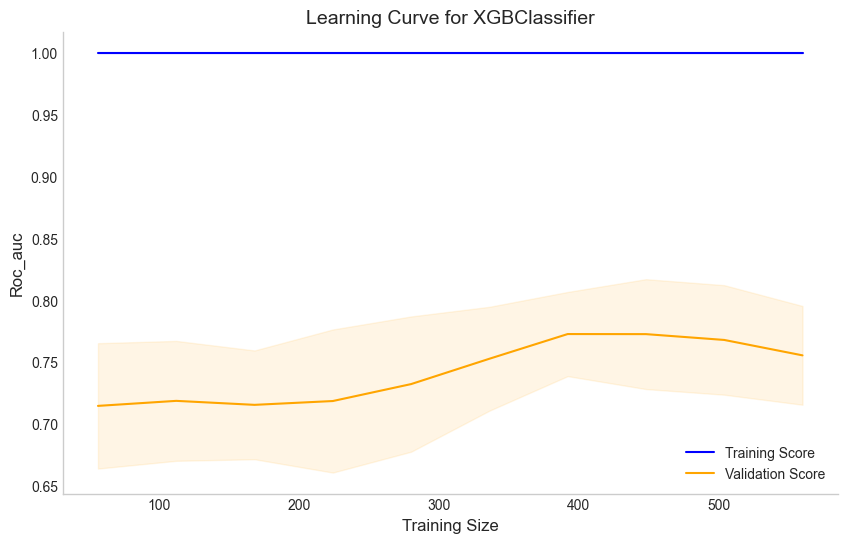

In [73]:
xgb_1 = train_model(xgb.XGBClassifier(random_state=RANDOM_STATE), train_df_enc_2, y_train, tag='xgb set 2', tracking=False, random_state=RANDOM_STATE)

In [77]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

voting_clf_2 = StackingClassifier(
    estimators=[
        ('svc', svc_2),
        ('log_reg', log_ref_2),
        ('xgb', xgb_1)
    ],
    final_estimator=LogisticRegression()
)

voting_clf_2 = train_model(voting_clf_2, train_df_enc_2, y_train, tag='voting clf set 2', tracking=False, random_state=RANDOM_STATE)

/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Training dataset: voting clf set 2


/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has fea

Training scores: ROC AUC=0.7856, F1=0.8529


/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has fea

KeyboardInterrupt: 

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

for model in [
    DummyClassifier(strategy='stratified'),
    LinearSVC(random_state=RANDOM_STATE),
    SVC(kernel='rbf', random_state=RANDOM_STATE),
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    LogisticRegression(random_state=RANDOM_STATE)
]:
    print(f"Learning curve for {model.__class__.__name__}")
    plot_learning_curve(model, train_df_enc, y_train, cv=5, scoring='roc_auc')



train function

Set up mlflow tracking URI and experiment name

model searfch spaces

In [31]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Example with SVC
svc_space = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(1e-4, 1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'poly', 'linear', 'sigmoid']),
    'tol': Real(1e-4, 1e-1, prior='log-uniform') 
}


log_reg_space = {
    'penalty': Categorical(['l1', 'l2']),
    'C': Real(0.01, 100, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter': Integer(100, 3000)
}

xgb_space = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0)
}

In [71]:
import xgboost as xgb

In [72]:
xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_bayes_search = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=xgb_space,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

NameError: name 'BayesSearchCV' is not defined

In [32]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
svc_tuned = BayesSearchCV(SVC(), svc_space, n_iter=50, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
log_reg_tuned = BayesSearchCV(LogisticRegression(random_state=RANDOM_STATE), log_reg_space, n_iter=50, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)

In [17]:
svc_tuned.fit(train_df_enc, y_train)
#log_reg_tuned.fit(train_df_enc, y_train)

NameError: name 'svc_tuned' is not defined

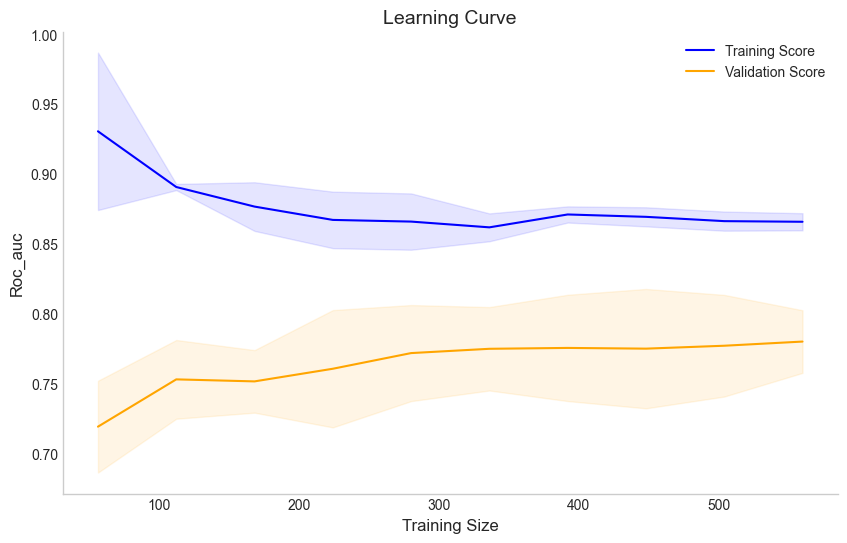

In [35]:
plot_learning_curve(svc_tuned.best_estimator_, train_df_enc, y_train, cv=5, scoring='roc_auc')


In [ ]:
plot_learning_curve(log_reg_tuned, train_df_enc, y_train, cv=5, scoring='roc_auc')

In [ ]:
svc_param_grid = {
    
}

In [ ]:
mlflow.set_tracking_uri("file://" + str(home / "mlruns"))
mlflow.set_experiment("credit-risk")

/Users/fotisn/code/repos/credit-risk-svm/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/03 17:58:41 INFO mlflow.tracking.fluent: Experiment with name 'credit-risk' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/fotisn/code/repos/credit-risk-svm/mlruns/715366904169799511', creation_time=1767455921477, experiment_id='715366904169799511', last_update_time=1767455921477, lifecycle_stage='active', name='credit-risk', tags={}>

In [17]:
from sklearn.model_selection import cross_val_score
from datetime import datetime
import warnings

def train_model(X_train, y_train, model, cv=5, scoring="roc_auc", random_state=RANDOM_STATE, run_name=None, **config):
    """
    Train a model and log everything to MLflow.
    
    Parameters:
    -----------
    X_train : array-like - Training features
    y_train : array-like - Training target
    model : sklearn estimator - Model instance to train
    cv : int - Number of cross-validation folds
    scoring : str - Scoring metric for CV
    random_state : int - Random state for reproducibility
    run_name : str, optional - Custom run name. If None, auto-generates from model name + timestamp
    **config : dict - Additional model parameters
    
    Returns:
    --------
    tuple: (trained_model, cv_scores)
    """
    # Get model class name
    model_name = model.__class__.__name__
    
    # Generate run name: ModelName_YYYYMMDD_HHMMSS
    if run_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_name = f"{model_name}_{timestamp}"
    
    with mlflow.start_run(run_name=run_name):

        
        
        
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        
        
        
        # Log individual fold scores
        for i, score in enumerate(cv_scores):
            mlflow.log_metric(f"cv_fold_{i+1}_{scoring}", score)
        
        # Fit model on full training data
        model.fit(X_train, y_train)
        
        #
        
        print(f"✅ {run_name} | CV {scoring}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        return model, cv_scores

### First baseline

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Define models and their configs
models_configs = [
    (DummyClassifier(), {"strategy": "most_frequent"}),
    (LinearSVC(), {}),
    (SVC(), {"kernel": "rbf"}),
    (RandomForestClassifier(), {}),
]

# Train all models with MLflow logging
results = {}
for model, config in models_configs:
    trained_model, cv_scores = train_model(
        train_df_enc, 
        y_train, 
        model, 
        cv=5, 
        scoring="roc_auc",
        **config
    )
    results[model.__class__.__name__] = {
        "model": trained_model,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std()
    }
    print(f"{model.__class__.__name__}: mean CV score = {cv_scores.mean():.4f}, std = {cv_scores.std():.4f}")

2026/01/04 16:04:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/04 16:04:25 INFO mlflow.store.db.utils: Updating database tables
2026/01/04 16:04:25 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/04 16:04:25 INFO mlflow.store.db.utils: Updating database tables
2026/01/04 16:04:25 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 16:04:25 INFO alembic.runtime.migration: Will assume non-transactional DDL.


✅ DummyClassifier_20260104_160425 | CV roc_auc: 0.5000 ± 0.0000
DummyClassifier: mean CV score = 0.5000, std = 0.0000
✅ LinearSVC_20260104_160425 | CV roc_auc: 0.7721 ± 0.0184
LinearSVC: mean CV score = 0.7721, std = 0.0184
✅ SVC_20260104_160425 | CV roc_auc: 0.7868 ± 0.0366
SVC: mean CV score = 0.7868, std = 0.0366
✅ RandomForestClassifier_20260104_160425 | CV roc_auc: 0.7802 ± 0.0398
RandomForestClassifier: mean CV score = 0.7802, std = 0.0398
✅ RandomForestClassifier_20260104_160425 | CV roc_auc: 0.7802 ± 0.0398
RandomForestClassifier: mean CV score = 0.7802, std = 0.0398


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Define models and their configs
models_configs = [
    (DummyClassifier(), {"strategy": "most_frequent"}),
    (LinearSVC(), {}),
    (SVC(), {"kernel": "rbf"}),
    (RandomForestClassifier(), {}),
]

# Train all models with MLflow logging
results = {}
for model, config in models_configs:
    trained_model, cv_scores = train_model(
        train_df_enc, 
        y_train, 
        model, 
        cv=5, 
        scoring="roc_auc",
        **config
    )
    results[model.__class__.__name__] = {
        "model": trained_model,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std()
    }
    print(f"{model.__class__.__name__}: mean CV score = {cv_scores.mean():.4f}, std = {cv_scores.std():.4f}")

✅ DummyClassifier_20260104_150507 | CV roc_auc: 0.5000 ± 0.0000
DummyClassifier: mean CV score = 0.5000, std = 0.0000
✅ LinearSVC_20260104_150507 | CV roc_auc: 0.7774 ± 0.0173
LinearSVC: mean CV score = 0.7774, std = 0.0173
✅ SVC_20260104_150507 | CV roc_auc: 0.7761 ± 0.0356
SVC: mean CV score = 0.7761, std = 0.0356
✅ RandomForestClassifier_20260104_150507 | CV roc_auc: 0.7876 ± 0.0319
RandomForestClassifier: mean CV score = 0.7876, std = 0.0319
✅ RandomForestClassifier_20260104_150507 | CV roc_auc: 0.7876 ± 0.0319
RandomForestClassifier: mean CV score = 0.7876, std = 0.0319


In [20]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Example with SVC
search_spaces = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(1e-4, 1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'poly', 'linear']),
    'tol': Real(1e-4, 1e-1, prior='log-uniform') 
}

opt = BayesSearchCV(SVC(), search_spaces, n_iter=20, cv=5, scoring='roc_auc')
opt.fit(train_df_enc, y_train)

,estimator,SVC()
,search_spaces,"{'C': Real(low=0.1,...m='normalize'), 'gamma': Real(low=0.00...m='normalize'), 'kernel': Categorical(c...), prior=None), 'tol': Real(low=0.00...m='normalize')}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


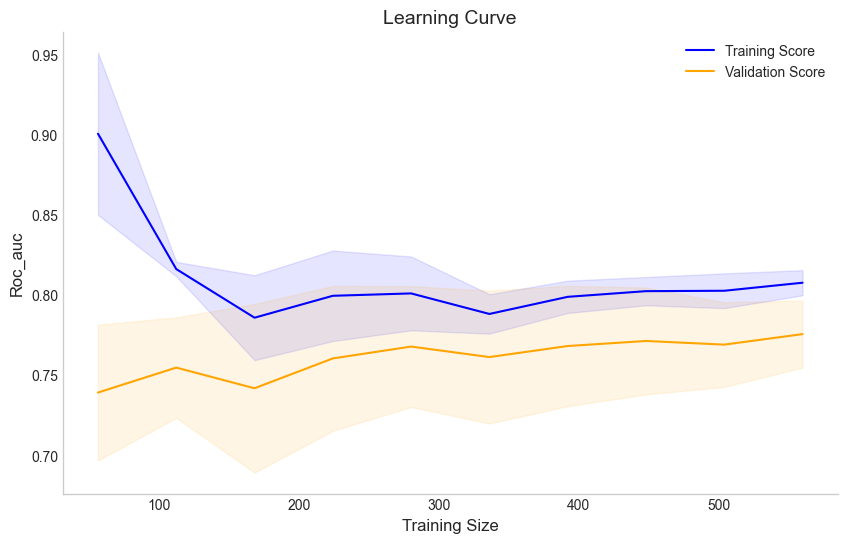

In [21]:
plot_learning_curve(opt.best_estimator_, train_df_enc, y_train, cv=5, scoring='roc_auc')

In [23]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(train_df_enc, y_train))
print("best params: %s" % str(opt.best_params_))

val. score: 0.7756182152830667
test score: 0.8061882512034393
best params: OrderedDict({'C': 70.25239282701969, 'gamma': 0.00010372058615264094, 'kernel': 'rbf', 'tol': 0.004072240152994773})


### Detailed enginnering feture by feature

1 - checking account status - Weight of evidence encoding

### Base models on engineered dataset

Scale for SVM

### Second baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


base_dummy = DummyClassifier(strategy="most_frequent")
base_svc = LinearSVC()
base_svc_rbf = SVC(kernel="rbf")
base_rf = RandomForestClassifier()

base_dummy.fit(train_df_enc, y_train)
base_svc.fit(train_df_enc, y_train)
base_svc_rbf.fit(train_df_enc, y_train)
base_rf.fit(train_df_enc, y_train)

score_1 = cross_val_score(base_dummy, train_df_enc, y_train, cv=5, scoring="roc_auc").mean()
score_2 = cross_val_score(base_svc, train_df_enc, y_train, cv=5, scoring="roc_auc").mean()
score_3 = cross_val_score(base_svc_rbf, train_df_enc, y_train, cv=5, scoring="roc_auc").mean()
score_4 = cross_val_score(base_rf, train_df_enc, y_train, cv=5, scoring="roc_auc").mean()

print(f"Dummy score : {score_1}", "\n", f"Linear SVM score : {score_2}", "\n", f"RBF SVM score : {score_3}", "\n", f"Random Forest score : {score_4}")

Dummy score : 0.5 
 Linear SVM score : 0.777379944148261 
 RBF SVM score : 0.7760561563848692 
 Random Forest score : 0.7743714775323686


In [ ]:

base_svc = LinearSVC()
base_svc_rbf = SVC(kernel="rbf")
base_rf = RandomForestClassifier()

base_svc.fit(engineered_train_df, y_train)
base_svc_rbf.fit(engineered_train_df, y_train)
base_rf.fit(engineered_train_df, y_train)

score_2 = cross_val_score(base_svc, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()
score_3 = cross_val_score(base_svc_rbf, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()
score_4 = cross_val_score(base_rf, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()

print(f"Linear SVM score : {score_2}", "\n", f"RBF SVM score : {score_3}", "\n", f"Random Forest score : {score_4}")

Linear SVM score : 0.75 
 RBF SVM score : 0.7442857142857143 
 Random Forest score : 0.7757142857142856


In [ ]:
from sklearn.model_selection import GridSearchCV

# Linear SVM tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced', {0: 1, 1: 5}],
    'max_iter': [2000]
}

grid = GridSearchCV(
    LinearSVC(),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(engineered_train_df, y_train)

print(f"Best AUC: {grid.best_score_:.4f}")
print(f"Best params: {grid.best_params_}")

# Expected: 0.80-0.82 AUC after tuning

Best AUC: 0.7878
Best params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000}


/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/pytho

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y):
    """
    Diagnose if you need more data, better features, or tuning
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring='roc_auc',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Diagnosis
    gap = train_mean[-1] - val_mean[-1]
    
    print("\n🔍 DIAGNOSIS:")
    if val_mean[-1] < 0.70:
        print("❌ Low validation score - Need better features or different model")
    if gap > 0.10:
        print("⚠️  High variance (overfitting) - Need regularization or more data")
    if gap < 0.05 and val_mean[-1] < 0.75:
        print("⚠️  High bias (underfitting) - Need more complex model or better features")
    if val_mean[-1] > 0.75 and gap < 0.10:
        print("✅ Good bias-variance tradeoff - Ready for tuning")




Learning curve for DummyClassifier


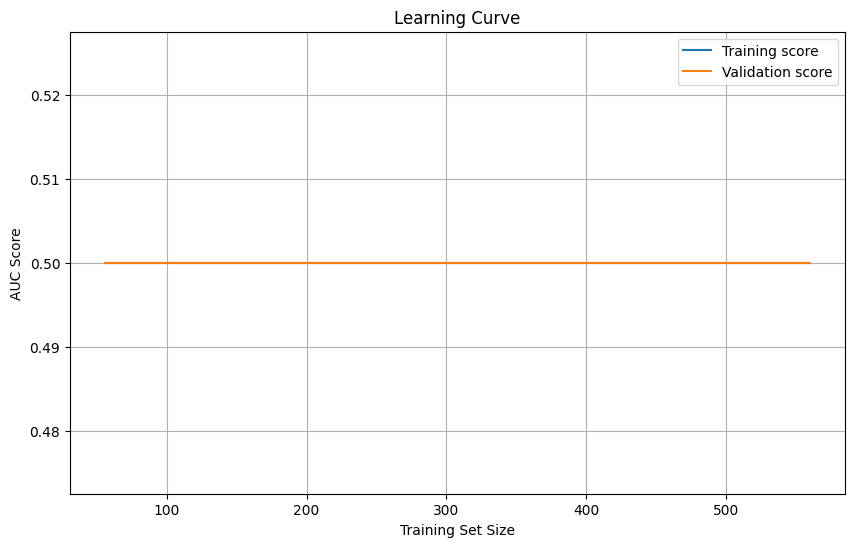


🔍 DIAGNOSIS:
❌ Low validation score - Need better features or different model
⚠️  High bias (underfitting) - Need more complex model or better features

Learning curve for LinearSVC


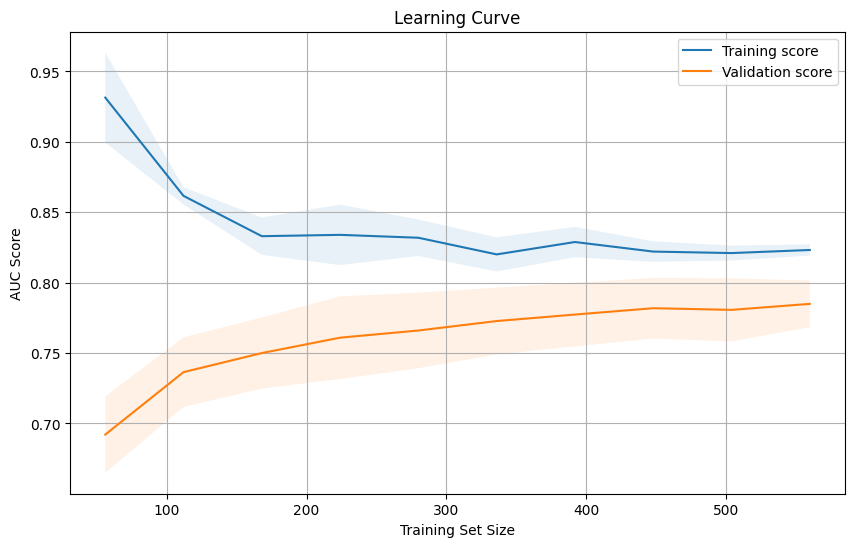


🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning

Learning curve for SVC


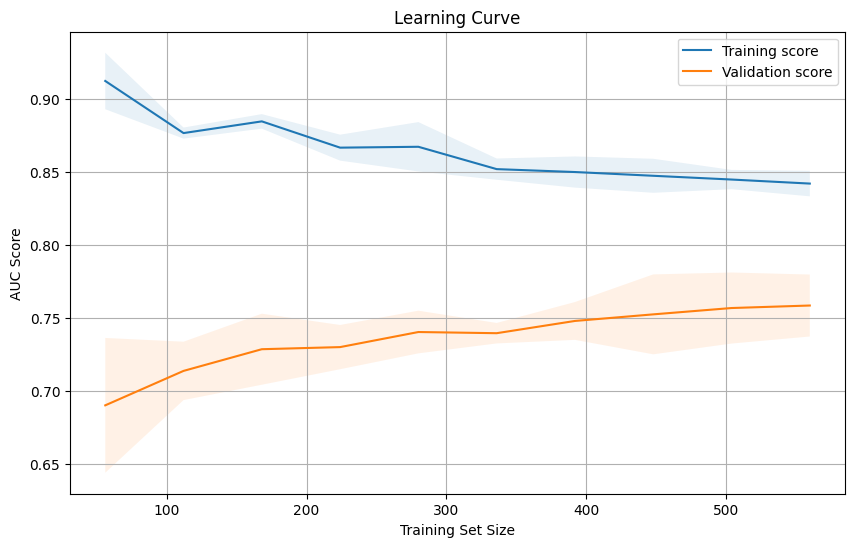


🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning

Learning curve for RandomForestClassifier


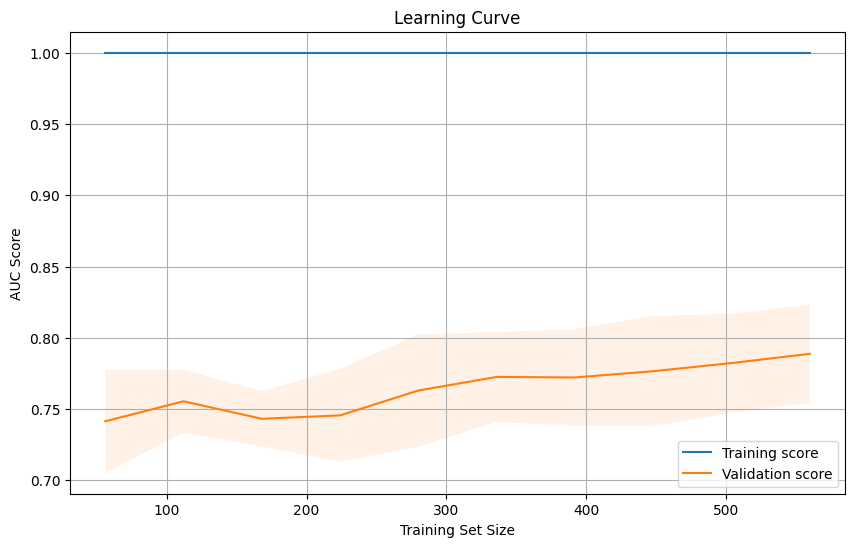


🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


In [ ]:
# Run for your best model
for model in [base_dummy ,base_svc, base_svc_rbf, base_rf]:
    print(f"\nLearning curve for {model.__class__.__name__}")
    plot_learning_curve(model, engineered_train_df, y_train)


In [ ]:
pd.DataFrame(base_rf.feature_importances_, index=engineered_train_df.columns, columns=["importance"]).sort_values(by="importance", ascending=False)

,importance
monthly_burden,0.156934
pct_x_amount,0.152426
checking_account_status,0.122144
duration_squared,0.116522
present_employment_since,0.063100
age_group,0.053683
credit_history,0.049416
savings_map,0.038616
other_installment_plans,0.031304
sex_map_male,0.024253


In [ ]:
engineered_train_df[[ "duration_squared", "monthly_burden", "pct_x_amount"]].corr()

,duration_squared,monthly_burden,pct_x_amount
duration_squared,1.000000,-0.073044,0.625180
monthly_burden,-0.073044,1.000000,0.219698
pct_x_amount,0.625180,0.219698,1.000000


In [ ]:
cols_to_drop

['other_debtors_guarantors',
 'job',
 'telephone',
 'foreign_worker',
 'present_residence_since',
 'existing_credits_count',
 'people_liable_for_maintenance']

In [ ]:
# Categorize your variables first
ordinal_vars = [
    'checking_account',      # Clear risk order
    'credit_history',        # VERY clear risk order
    'savings_account',       # Amount ranges
    'employment',            # Duration ranges
    'other_installment_plans', # None < Bank < Stores
    'job'                    # Skill level order
]

nominal_vars = [
    'purpose',              # No natural order
    'personal_status_sex',  # Categorical combinations
    'other_debtors',        # Types of support
    'property',             # Different asset types
    'housing'               # Different situations
]

binary_vars = [
    'telephone',            # Yes/No
    'foreign_worker'        # Yes/No
]

# Apply WoE to ordinal
for var in ordinal_vars:
    woe_map, woe_table = calculate_woe(df, var, 'target')
    df[f'{var}_woe'] = df[var].map(woe_map)
    
    # Calculate IV to check predictive power
    iv = calculate_iv(woe_table)
    print(f"{var} IV: {iv:.4f}")

# Apply One-Hot to nominal
for var in nominal_vars:
    df_temp = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df = pd.concat([df, df_temp], axis=1)

# Binary variables stay as 0/1
# (already encoded in dataset)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Automatically select categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder(
    categories="auto",
    drop="first",  # to return k-1, use drop=false to return k dummies
    sparse_output=False,
    handle_unknown="error",  # helps deal with rare labels
)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

preprocessor.set_output(transform="pandas")

preprocessor.fit(train_df)

### Engineering pipeline

### Testing

<hr>